<a href="https://colab.research.google.com/github/julianopcardoso/cnnbridgedamagedetection/blob/main/Projeto_final_Modelos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Disciplina: Aprendizado Profundo 02/2023**

Professor:
Anderson Rocha Tavares

Grupo:
Daniele Kauctz,
Gabriel Beretta,
Juliano Cardoso

<br>

---

## Detecção de danos estruturais em pontes através de Rede Neurais Artificiais





Identificar possíveis danos estruturais em pontes através de análise de sensores de aceleração utilizando séries temporais.

Esses sensores de aceleração (acelerômetros) são capazes de identificar vibrações em qualquer estrutura. Essas vibrações ocorrem de acordo com as características do sistema sendo uma propriedade sensível ao dano.

Os dados de entrada são valores de aceleração (m/s²) ao longo do tempo no cenários íntegros e danificados.

<br>

Dataset: Old_ADA_Bridge-damage_vibration_data

Related work: Ambient and Vehicle-Induced Vibration Data of a Steel Truss Bridge Subject to Artificial Damage



## Importação das bibliotecas

In [ ]:
import os #importa módulo para manipulação e arquivos
import numpy as np #importa numpy
from matplotlib import pyplot as plt #importa bilbioteca para criação de gráficos
import seaborn as sns #importa biblioteca para geração de gráficos
import pandas as pd  #importa bibioteca responsável para o tratamento e limpeza dos dados
from glob import glob #importa biblioteca para trabalhar com os diretórios das imagens
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report #importa biblioteca de métricas (acurácia, matrix de confusão e relatório de classifição)
from tensorflow.keras.preprocessing.image import ImageDataGenerator  #importa biblioteca para trabalhar com imagens
from tensorflow.keras import models, layers #importa biblioteca para trabalhar com modelos e camadas de rede neural (CNN)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint #importa bibliotecas que faz modelo parar de treinar quando uma métrica monitorada para de melhorar.
from google.colab import files #importa biblioteca do google colab para realizar upload de arquivos para o projeto
from gc import callbacks #importa biblioca de retorno de chamada para monitorar treinamento
from google.colab import drive

In [ ]:
# Plotagem
! sudo apt-get update
! sudo apt-get install texlive-latex-recommended
! sudo apt-get install dvipng texlive-latex-extra texlive-fonts-recommended
! wget http://mirrors.ctan.org/macros/latex/...
! unzip type1cm.zip -d /tmp/type1cm
! cd /tmp/type1cm/type1cm/ && sudo latex type1cm.ins
! sudo mkdir /usr/share/texmf/tex/latex/type1cm
! sudo cp /tmp/type1cm/type1cm/type1cm.sty /usr/share/texmf/tex/latex/type1cm
! sudo texhash
!apt install cm-super

import matplotlib
from matplotlib import rc
rc('font',**{'family':'Times New Roman','size' :12})
matplotlib.rcParams['axes.unicode_minus'] = False
matplotlib.rc('text', usetex=True)
matplotlib.rc('axes', labelsize=12)
matplotlib.rc('xtick', labelsize=12)
matplotlib.rc('ytick', labelsize=12)
matplotlib.rc('lines', lw=1.0,color='k')
matplotlib.rc('axes',lw=0.75)
matplotlib.rc('legend', fontsize=10)

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Hit:5 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [664 kB]
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates/multiverse amd64 Packages [50.4 kB]
Get:8 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,322 kB]
Get:9 http://archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [1,709 kB]
Get:10 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [1,667 kB]
Get:11 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease [18.1 kB]
Get:12 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelea

## Download do dataset

In [ ]:
# Faz download do dataset
drive.mount('/content/drive', force_remount=True) # Não esquecer de ajustas os PATHS

Mounted at /content/drive


## Análise Exploratória e Pré-Processamento das Imagens


Análise dos diretórios de Treinamento e Validação

In [ ]:
# Diretório para amostras
base_dir = "/content/drive/<PATH_TO_IMAGES>/imagens"

# Diretório para amostras de treino
train_dir = os.path.join(base_dir, 'train')
# Diretório para amostras de teste
test_dir = os.path.join(base_dir, 'test')
# Diretório para amostras de Validação
val_dir = os.path.join(base_dir, 'val')

Exibe exemplo de cada classe

(-0.5, 155.5, 155.5, -0.5)

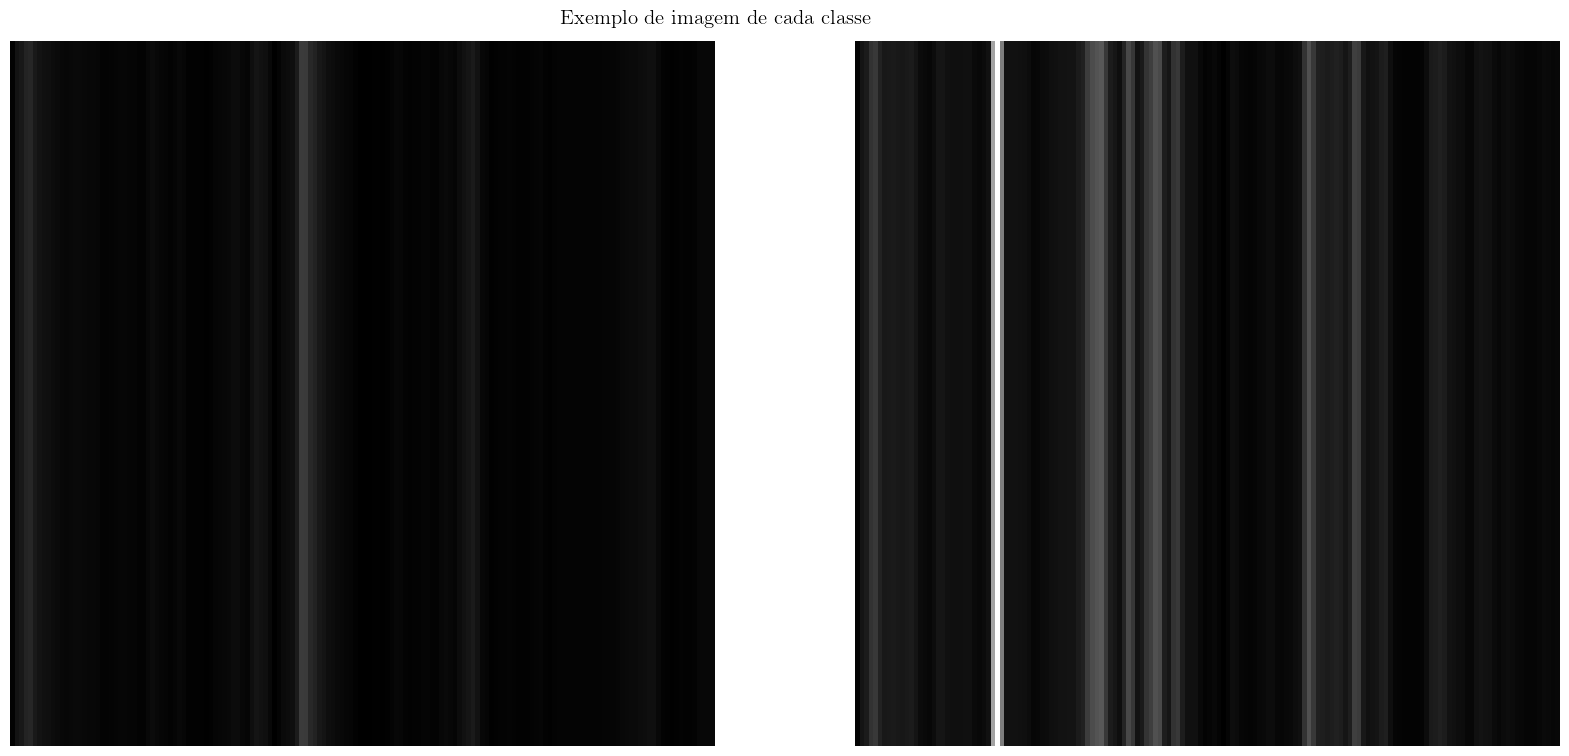

In [ ]:
# Cria subplote para exibir 1 imagem de cada classe
fig,axis = plt.subplots(1,2,figsize=(20,20))
fig.text(s="Exemplo de imagem de cada classe",y=0.68,x=0.4,size=15)

# Exibe 1 imagem com a classe 0
img = f'{train_dir}/dmg/image_dmg_488_1.png'
img = plt.imread(img)
axis[0].imshow(img)
axis[0].set_title('')
axis[0].axis('off')

# Exibe 1 imagem com a classe 1
img = f'{train_dir}/int/image_int_10_2.png'
img = plt.imread(img)
axis[1].imshow(img)
axis[1].set_title('')
axis[1].axis('off')

Quantidade de imagens de cada classe

In [ ]:
# Contabiliza quantidade de imagens de treino e validação - Sem dano
imagensSemDanoTrain = len(glob(train_dir+"/int"+"/*"))
imagensSemDanoVal = len(glob(val_dir+"/int"+"/*"))
imagensSemDanoTest = len(glob(test_dir+"/int"+"/*"))
imagensSemDano = imagensSemDanoTrain + imagensSemDanoVal + imagensSemDanoTest

# Contabiliza quantidade de imagens de treino e validação - Com dano
imagensComDanoTrain = len(glob(train_dir+"/dmg"+"/*"))
imagensComDanoVal = len(glob(val_dir+"/dmg"+"/*"))
imagensComDanoTest = len(glob(test_dir+"/dmg"+"/*"))
imagensComDano = imagensComDanoTrain + imagensComDanoVal + imagensComDanoTest

# Exibe totais e percentuais de imagens para teste e validação
print("Total de imagens sem dano: {0} - Treino: {1} ({2}%) Validação: {3} ({4}%) Teste: {5} ({6}%)".format(imagensSemDano, imagensSemDanoTrain, round((imagensSemDanoTrain/imagensSemDano)*100,2),
                                                                                  imagensSemDanoVal, round((imagensSemDanoVal/imagensSemDano)*100,2),
                                                                                  imagensSemDanoTest, round((imagensSemDanoTest/imagensSemDano)*100,2)))

print("Total de imagens com dano: {0} - Treino: {1} ({2}%) Validação: {3} ({4}%)  Teste: {5} ({6}%)".format(imagensComDano, imagensComDanoTrain, round((imagensComDanoTrain/imagensComDano)*100,2),
                                                                                          imagensComDanoVal, round((imagensComDanoVal/imagensComDano)*100,2),
                                                                                          imagensComDanoTest, round((imagensComDanoTest/imagensComDano)*100,2)))


Total de imagens sem dano: 4277 - Treino: 3208 (75.01%) Validação: 855 (19.99%) Teste: 214 (5.0%)
Total de imagens com dano: 3423 - Treino: 2567 (74.99%) Validação: 685 (20.01%)  Teste: 171 (5.0%)


Gráfico - Quantidade de imagens por classe

In [ ]:
# Tabula quantidade de imagens em dataframe
df_imagens = pd.DataFrame(data={'classe':['Sem Dano','Com Dano'] , 'quantidade':[imagensSemDano, imagensComDano]})

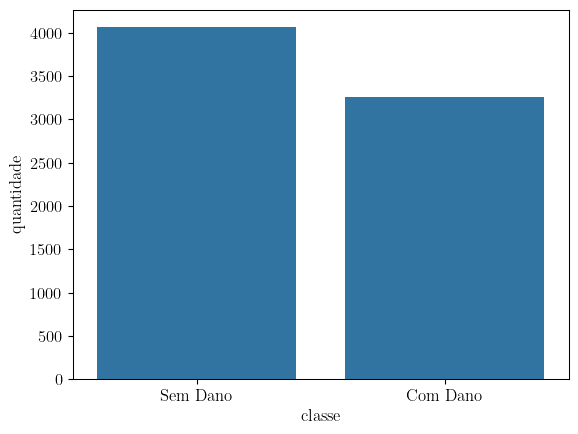

In [ ]:
# Plotagem da quantidade de imagens
ax = sns.barplot(x='classe', y='quantidade', data=df_imagens)

Prepara datasets


In [ ]:
# Transforma escala de pixels para o intervalo 0 e 1
image_gen = ImageDataGenerator(rescale = 1./255)
test_data_gen = ImageDataGenerator(rescale = 1./255)

img_height = 150
img_width = 150
batch_size = 64
channels = 3

# Gera lote de imagens para ser lidas a partir do diretório de Treino
train_generator = image_gen.flow_from_directory(directory=train_dir,
                                                target_size=(img_height, img_width),
                                                batch_size=batch_size,
                                                class_mode="categorical",
                                                shuffle=True,)

# Gera lote de imagens para ser lidas a partir do diretório de Validação
val_generator = test_data_gen.flow_from_directory(directory=val_dir,
                                               target_size=(img_height, img_width),
                                               batch_size=batch_size,
                                               class_mode="categorical",
                                               shuffle=False,)

# Gera lote de imagens para ser lidas a partir do diretório de Teste
test_generator = test_data_gen.flow_from_directory(directory=test_dir,
                                                  target_size=(img_height, img_width),
                                                  batch_size=batch_size,
                                                  class_mode=None,
                                                  shuffle=False,)

Found 5775 images belonging to 2 classes.
Found 1540 images belonging to 2 classes.
Found 385 images belonging to 2 classes.


## Modelagem

In [ ]:
# Cria input layer para serem trabalhados nos modelos
input_layer=layers.Input(shape=(img_height,img_width,channels))

In [ ]:
# Monitora treinamento e para quando não houver mais redução do val_loss
early = EarlyStopping(monitor="val_loss",
                      mode="min",
                      patience=3)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.3, min_lr=0.00001)
callbacks_list = [ early, learning_rate_reduction]

### Densenet

In [ ]:
reduce_learning = ReduceLROnPlateau(
    monitor='loss',
    factor=0.2,
    patience=2,
    verbose=1,
    mode='auto',
    min_delta=0.0001,
    cooldown=2,
    min_lr=0)

eary_stopping = EarlyStopping(
    monitor='loss',
    min_delta=0,
    patience=7,
    verbose=1,
    mode='auto')
callbacks_x = [reduce_learning, eary_stopping]

In [ ]:
# Importa bibliotecas necessárias para o DenseNet121
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input, decode_predictions

# Define hiperparâmetros do modelo
base_model = DenseNet121(
    include_top=False,
    weights="imagenet")

# Cria camada de saída para suportar a classificação de 02 classes com função de ativação softmax
global_avg_pooling = layers.GlobalAveragePooling2D()(base_model.output)
dropout = layers.Dropout(rate=0.5)(global_avg_pooling)
output = layers.Dense(2, activation='softmax')(dropout)
modelDenseNet = models.Model(inputs=base_model.input, outputs=output)

29084464/29084464 [==============================] - 1s 0us/step


In [ ]:
# Compila modelo
modelDenseNet.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# Gera Resumo do modelo
modelDenseNet.summary()

In [ ]:
# Realiza o treinamento do modelo
historyDenseNet = modelDenseNet.fit(train_generator, epochs=50, validation_data=val_generator, verbose=1, callbacks=callbacks_x)

Epoch 1/50
91/91 [==============================] - 2546s 28s/step - loss: 0.6408 - accuracy: 0.7008 - val_loss: 0.9915 - val_accuracy: 0.6123 - lr: 0.0010
Epoch 2/50
91/91 [==============================] - 24s 266ms/step - loss: 0.3767 - accuracy: 0.8163 - val_loss: 0.5573 - val_accuracy: 0.7981 - lr: 0.0010
Epoch 3/50
91/91 [==============================] - 24s 260ms/step - loss: 0.3135 - accuracy: 0.8630 - val_loss: 0.3929 - val_accuracy: 0.8253 - lr: 0.0010
Epoch 4/50
91/91 [==============================] - 24s 261ms/step - loss: 0.2278 - accuracy: 0.9027 - val_loss: 0.3135 - val_accuracy: 0.8461 - lr: 0.0010
Epoch 5/50
91/91 [==============================] - 24s 260ms/step - loss: 0.2098 - accuracy: 0.9119 - val_loss: 0.2604 - val_accuracy: 0.8877 - lr: 0.0010
Epoch 6/50
91/91 [==============================] - 24s 260ms/step - loss: 0.1822 - accuracy: 0.9273 - val_loss: 0.3089 - val_accuracy: 0.8526 - lr: 0.0010
Epoch 7/50
91/91 [==============================] - 24s 264ms/st

Métricas

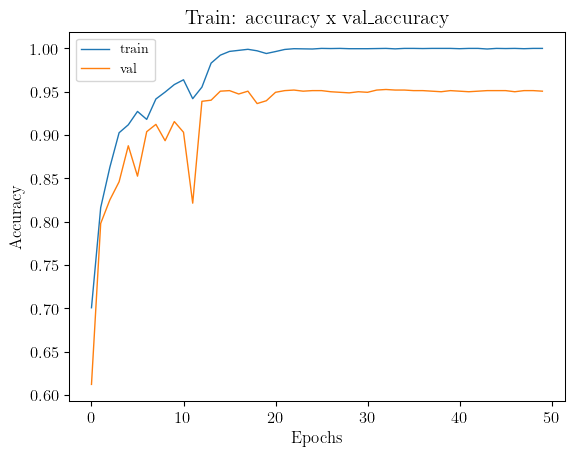

In [ ]:
# Gráfico de accuracy x val_accuracy
plt.plot(historyDenseNet.history['accuracy'], label='accuracy')
plt.plot(historyDenseNet.history['val_accuracy'], label = 'val_accuracy')
plt.title('Train: accuracy x val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train','val'])

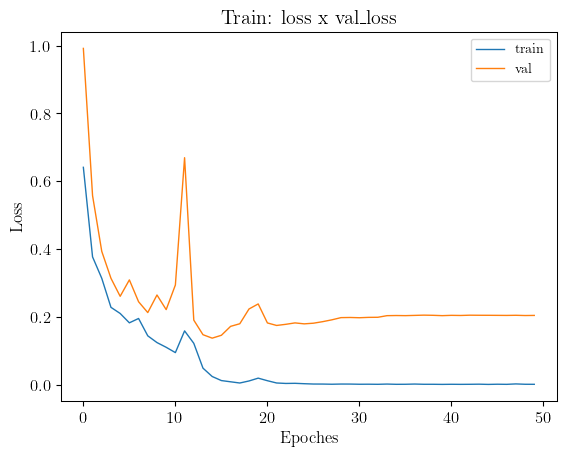

In [ ]:
# Gráfico de loss x val_loss
plt.plot(historyDenseNet.history['loss'], label='loss')
plt.plot(historyDenseNet.history['val_loss'], label = 'val_loss')
plt.title('Train: loss x val_loss')
plt.xlabel('Epoches')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.legend(['train','val'])

<Axes: >

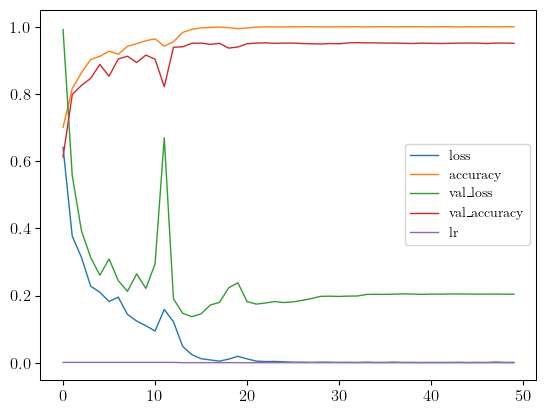

In [ ]:
# Gráfico de loss x val_loss e accurancy x val_accurancy
pd.DataFrame(modelDenseNet.history.history).plot()

In [ ]:
# Realiza predição do dataset de Validação
val_generator.reset()
pred=modelDenseNet.predict(val_generator, verbose=1)
predicted_class_indices=np.argmax(pred,axis=1)

25/25 [==============================] - 249s 10s/step


In [ ]:
# Calcula a acurácia do dataset de Validação
acuracia = accuracy_score(val_generator.classes, predicted_class_indices)
print("A acurácia é de {0}%".format(round(acuracia * 100,2)))

A acurácia é de 95.06%


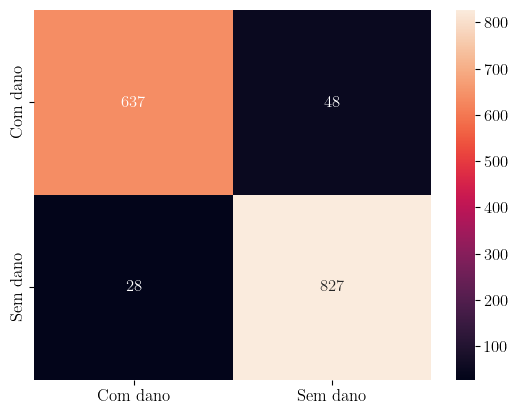

In [ ]:
# Platagem da matrix de confusão do dataset de Validação
cm = pd.DataFrame(data=confusion_matrix(val_generator.classes, predicted_class_indices))
sns.heatmap(cm,annot=True,fmt="d", xticklabels=['Com dano', 'Sem dano'], yticklabels=['Com dano', 'Sem dano'])
plt.savefig("val_matrix.pdf", format='pdf')

In [ ]:
# Relatório de classificação do modelo para o dataset de Validação
print(classification_report(val_generator.classes, predicted_class_indices, digits=4, target_names=['Com dano', 'Sem dano']))

              precision    recall  f1-score   support

    Com dano     0.9579    0.9299    0.9437       685
    Sem dano     0.9451    0.9673    0.9561       855

    accuracy                         0.9506      1540
   macro avg     0.9515    0.9486    0.9499      1540
weighted avg     0.9508    0.9506    0.9506      1540



Testes

In [ ]:
# Realiza predição do dataset de Testes
test_generator.reset()
predtest=modelDenseNet.predict(test_generator, verbose=1)
predictedTest_class_indices=np.argmax(predtest,axis=1)

7/7 [==============================] - 201s 33s/step


In [ ]:
# Calcula a acurácia do dataset de Testes
acuraciaTest = accuracy_score(test_generator.classes, predictedTest_class_indices)
print("A acurácia é de {0}%".format(round(acuraciaTest * 100,2)))

A acurácia é de 95.06%


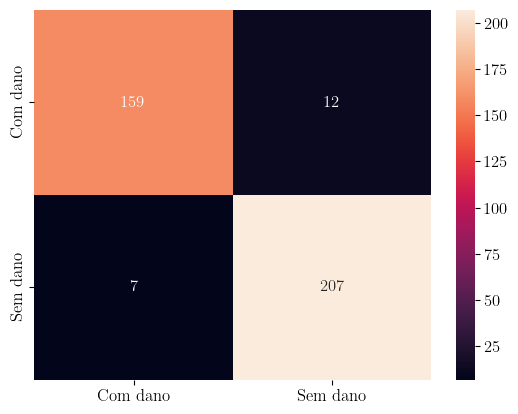

In [ ]:
# Platagem da matrix de confusão do dataset de Testes
cmTest = pd.DataFrame(data=confusion_matrix(test_generator.classes, predictedTest_class_indices))
sns.heatmap(cmTest,annot=True,fmt="d", xticklabels=['Com dano', 'Sem dano'], yticklabels=['Com dano', 'Sem dano'])
plt.savefig("test_matrix.pdf", format='pdf')

In [ ]:
# Relatório de classificação do modelo para o dataset de Testes
print(classification_report(test_generator.classes, predictedTest_class_indices, digits=4, target_names=['Com dano', 'Sem Dano']))

              precision    recall  f1-score   support

    Com dano     0.9578    0.9298    0.9436       171
    Sem Dano     0.9452    0.9673    0.9561       214

    accuracy                         0.9506       385
   macro avg     0.9515    0.9486    0.9499       385
weighted avg     0.9508    0.9506    0.9506       385



In [ ]:
# Mostra classificação - percentual de classificação - rótulo verdadeiro da imagem
classes = {0: 'Com dano', 1:'Sem dano'}
imagens = np.concatenate([test_generator[i] for i in range(test_generator.__len__())])
i = 25
previsto = np.argmax(predtest[i])
percentual = np.max(predtest[i])
real = test_generator.classes[i]
imagemReal = imagens[i]

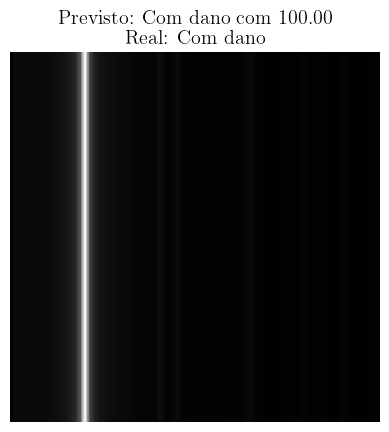

In [ ]:
# Plota predição de teste
plt.title('Previsto: ' + classes[previsto] + ' com ' + '{:.2%}'.format(round(percentual,2)) + '. \nReal: ' + classes[real])
plt.imshow(np.squeeze(imagemReal))
plt.axis('off')
plt.show()

In [ ]:
# Plota predições de teste
classes = {0: 'Sem dano', 1:'Com dano'}
imagens = np.concatenate([test_generator[i] for i in range(test_generator.__len__())])
plt.figure(figsize=(20, 20))
start = 0

for i in range(0, 16):

    plt.subplot(4, 4, i+1)

    # Mostra classificação - percentual de classificação - rótulo verdadeiro da imagem
    previsto = np.argmax(predtest[i])
    percentual = np.max(predtest[i])
    real = test_generator.classes[i]
    imagemReal = imagens[i]
    plt.title('Classificado como ' + classes[previsto] + ' com ' + '{:.2%}'.format(round(percentual,2)) + '. \nRótulo verdadeiro: ' + classes[real])
    plt.axis('off')
    plt.imshow(np.squeeze(imagemReal))

plt.tight_layout()
plt.show()

Salva modelo

In [ ]:
modelDenseNet.save("/content/drive/<PATH_TO_MODELS>/modelos/densenet.h5")

### ResNet50

In [ ]:
# Importa bibliotecas necessárias para o ResNet50
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

# Define hiperparâmetros do modelo
modelResnet = ResNet50(input_tensor=input_layer,
    include_top=False,
    weights="imagenet")

# Cria cadama de saída para suportar a classificação de 04 com função de ativação softmax
last_layer=modelResnet.output
flatten=layers.Flatten()(last_layer)
output_layer=layers.Dense(2,activation='softmax')(flatten)
modelResnet=models.Model(inputs=input_layer,outputs=output_layer)

In [ ]:
# Compila modelo
modelResnet.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

In [ ]:
# Gera Resumo do modelo
modelResnet.summary()

In [ ]:
# Realiza o treinamento do modelo
historyResnet = modelResnet.fit(train_generator, epochs=50, validation_data=val_generator, verbose=1, callbacks=callbacks_x)

Epoch 1/50
91/91 [==============================] - 52s 264ms/step - loss: 1.7662 - accuracy: 0.7022 - val_loss: 0.8285 - val_accuracy: 0.5552 - lr: 0.0010
Epoch 2/50
91/91 [==============================] - 23s 257ms/step - loss: 0.7235 - accuracy: 0.7765 - val_loss: 0.6835 - val_accuracy: 0.5552 - lr: 0.0010
Epoch 3/50
91/91 [==============================] - 23s 255ms/step - loss: 0.5030 - accuracy: 0.8087 - val_loss: 3.1372 - val_accuracy: 0.5552 - lr: 0.0010
Epoch 4/50
91/91 [==============================] - 23s 251ms/step - loss: 0.3446 - accuracy: 0.8575 - val_loss: 0.6257 - val_accuracy: 0.6565 - lr: 0.0010
Epoch 5/50
91/91 [==============================] - 23s 257ms/step - loss: 0.2457 - accuracy: 0.8977 - val_loss: 0.6509 - val_accuracy: 0.6052 - lr: 0.0010
Epoch 6/50
91/91 [==============================] - 23s 257ms/step - loss: 0.2091 - accuracy: 0.9103 - val_loss: 0.8178 - val_accuracy: 0.6000 - lr: 0.0010
Epoch 7/50
91/91 [==============================] - 22s 246ms/st

Métricas

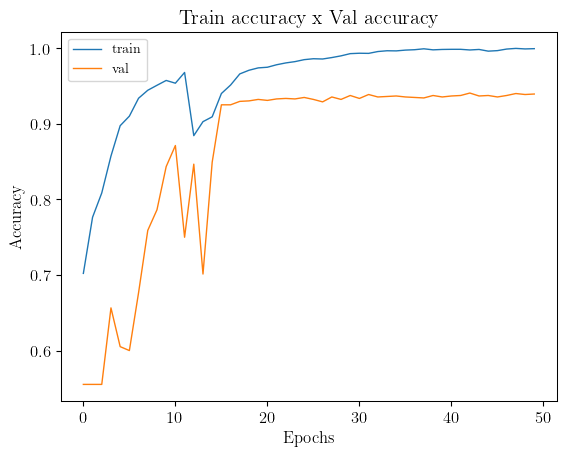

In [ ]:
# Gráfico de accurancy x val_accurancy
plt.plot(historyResnet.history['accuracy'], label='accuracy')
plt.plot(historyResnet.history['val_accuracy'], label = 'val_accuracy')
plt.title('Train accuracy x Val accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train','val'])

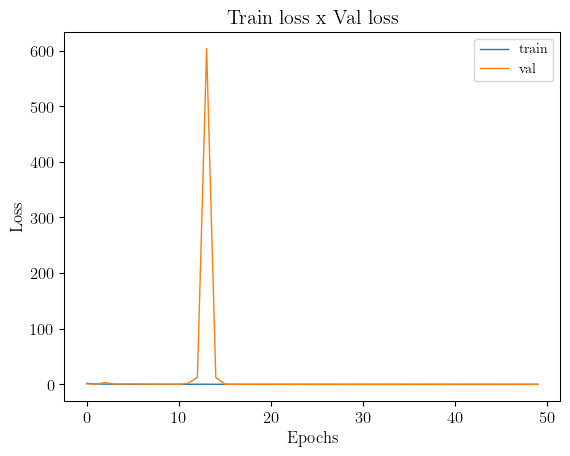

In [ ]:
# Gráfico de loss x val_loss
plt.plot(historyResnet.history['loss'], label='loss')
plt.plot(historyResnet.history['val_loss'], label = 'val_loss')
plt.title('Train loss x Val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.legend(['train','val'])

<Axes: >

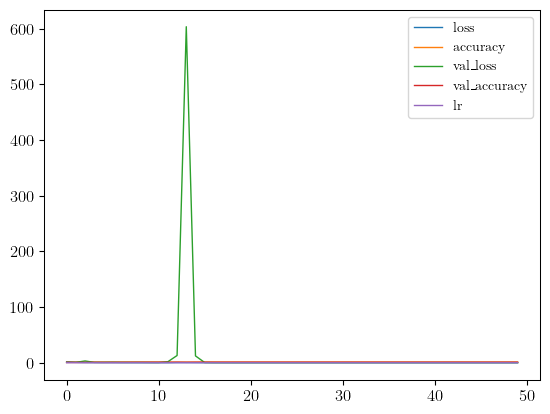

In [ ]:
# Gráfico de loss x val_loss e accurancy x val_accurancy
pd.DataFrame(modelResnet.history.history).plot()

In [ ]:
# Realiza predição do dataset de Validação
val_generator.reset()
pred=modelResnet.predict(val_generator, verbose=1)
predicted_class_indices=np.argmax(pred,axis=1)

25/25 [==============================] - 5s 194ms/step


In [ ]:
# Calcula a acurácia do dataset de Validação
acuracia = accuracy_score(val_generator.classes, predicted_class_indices)
print("A acurácia é de {0}%".format(round(acuracia * 100,2)))

A acurácia é de 93.96%


<Axes: >

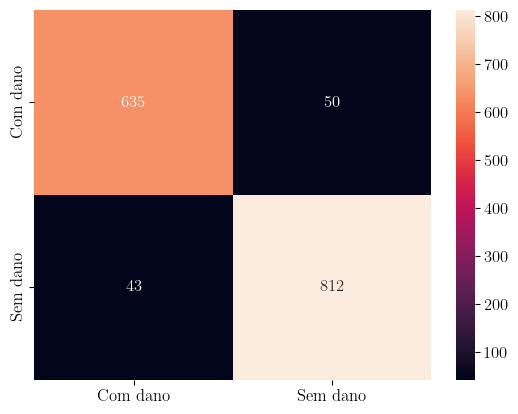

In [ ]:
# Platagem da matrix de confusão do dataset de Validação
cm = pd.DataFrame(data=confusion_matrix(val_generator.classes, predicted_class_indices))
sns.heatmap(cm,annot=True,fmt="d", xticklabels=['Com dano', 'Sem dano'], yticklabels=['Com dano', 'Sem dano'])

In [ ]:
# Relatório de classificação do modelo para o dataset de Validação
print(classification_report(val_generator.classes, predicted_class_indices, digits=4, target_names=['Com dano', 'Sem dano']))

              precision    recall  f1-score   support

    Com dano     0.9366    0.9270    0.9318       685
    Sem dano     0.9420    0.9497    0.9458       855

    accuracy                         0.9396      1540
   macro avg     0.9393    0.9384    0.9388      1540
weighted avg     0.9396    0.9396    0.9396      1540



Testes

In [ ]:
# Realiza predição do dataset de Testes
test_generator.reset()
predtest=modelResnet.predict(test_generator, verbose=1)
predictedTest_class_indices=np.argmax(predtest,axis=1)

7/7 [==============================] - 1s 172ms/step


In [ ]:
# Calcula a acurácia do dataset de Testes
acuraciaTest = accuracy_score(test_generator.classes, predictedTest_class_indices)
print("A acurácia é de {0}%".format(round(acuraciaTest * 100,2)))

A acurácia é de 94.55%


<Axes: >

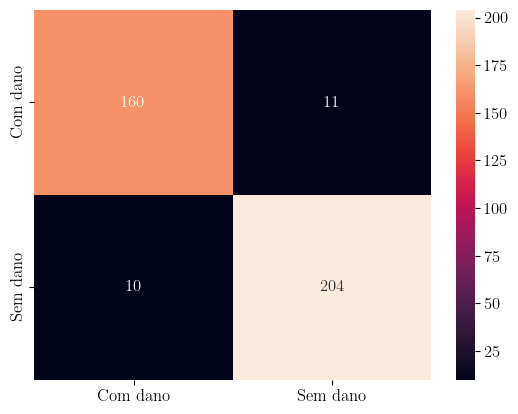

In [ ]:
# Platagem da matrix de confusão do dataset de Testes
cmTest = pd.DataFrame(data=confusion_matrix(test_generator.classes, predictedTest_class_indices))
sns.heatmap(cmTest,annot=True,fmt="d", xticklabels=['Com dano', 'Sem dano'], yticklabels=['Com dano', 'Sem dano'])

In [ ]:
# Relatório de classificação do modelo para o dataset de Testes
labels = (test_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
print(classification_report(test_generator.classes, predictedTest_class_indices, digits=4, target_names=['Com dano', 'Sem Dano']))

              precision    recall  f1-score   support

    Com dano     0.9412    0.9357    0.9384       171
    Sem Dano     0.9488    0.9533    0.9510       214

    accuracy                         0.9455       385
   macro avg     0.9450    0.9445    0.9447       385
weighted avg     0.9454    0.9455    0.9454       385



In [ ]:
# Mostra classificação - percentual de classificação - rótulo verdadeiro da imagem
classes = {0: 'Com dano', 1:'Sem dano'}
imagens = np.concatenate([test_generator[i] for i in range(test_generator.__len__())])
i = 44
previsto = np.argmax(predtest[i])
percentual = np.max(predtest[i])
real = test_generator.classes[i]
imagemReal = imagens[i]

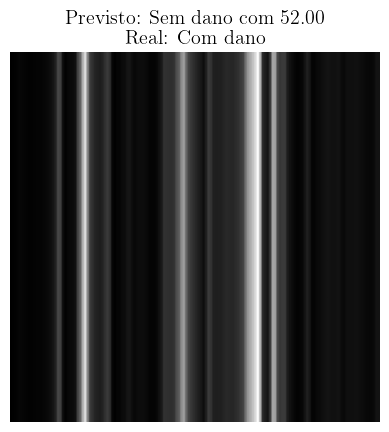

In [ ]:
# Plota predição de teste
plt.title('Previsto: ' + classes[previsto] + ' com ' + '{:.2%}'.format(round(percentual,2)) + '. \nReal: ' + classes[real])
plt.imshow(np.squeeze(imagemReal))
plt.axis('off')
plt.show()

In [ ]:
# Plota predições de teste
classes = {0: 'Sem dano', 1:'Com dano'}
imagens = np.concatenate([test_generator[i] for i in range(test_generator.__len__())])
plt.figure(figsize=(20, 20))
start = 0

for i in range(0, 16):

    plt.subplot(4, 4, i+1)

    # Mostra classificação - percentual de classificação - rótulo verdadeiro da imagem
    previsto = np.argmax(predtest[i])
    percentual = np.max(predtest[i])
    real = test_generator.classes[i]
    imagemReal = imagens[i]
    plt.title('Classificado como ' + classes[previsto] + ' com ' + '{:.2%}'.format(round(percentual,2)) + '. \nRótulo verdadeiro: ' + classes[real])
    plt.axis('off')
    plt.imshow(np.squeeze(imagemReal))

plt.tight_layout()
plt.show()

### InceptionV3

In [ ]:
# Importa bibliotecas necessárias para o InceptionV3
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input, decode_predictions

# Define hiperparâmetros do modelo
modelInception = InceptionV3(input_tensor=input_layer,
    include_top=False,
    weights="imagenet")

# Cria cadama de saída para suportar a classificação de 04 com função de ativação softmax
last_layer=modelInception.output
flatten=layers.Flatten()(last_layer)
output_layer=layers.Dense(2,activation='softmax')(flatten)
modelInception=models.Model(inputs=input_layer,outputs=output_layer)

87910968/87910968 [==============================] - 3s 0us/step


In [ ]:
# Compila modelo
modelInception.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

In [ ]:
# Gera Resumo do modelo
modelInception.summary()

In [ ]:
# Realiza o treinamento do modelo
historyInception = modelInception.fit(train_generator, epochs=50, validation_data=val_generator, verbose=1, callbacks=callbacks_x)

Epoch 1/50
91/91 [==============================] - 61s 296ms/step - loss: 0.6992 - accuracy: 0.7022 - val_loss: 40.3443 - val_accuracy: 0.6136 - lr: 0.0010
Epoch 2/50
91/91 [==============================] - 24s 268ms/step - loss: 0.3690 - accuracy: 0.8281 - val_loss: 0.8277 - val_accuracy: 0.8234 - lr: 0.0010
Epoch 3/50
91/91 [==============================] - 23s 255ms/step - loss: 0.4464 - accuracy: 0.8403 - val_loss: 1559.1411 - val_accuracy: 0.6903 - lr: 0.0010
Epoch 4/50
91/91 [==============================] - ETA: 0s - loss: 0.5308 - accuracy: 0.8024
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
91/91 [==============================] - 24s 265ms/step - loss: 0.5308 - accuracy: 0.8024 - val_loss: 15803.6797 - val_accuracy: 0.5506 - lr: 0.0010
Epoch 5/50
91/91 [==============================] - 24s 262ms/step - loss: 0.3533 - accuracy: 0.8423 - val_loss: 0.6945 - val_accuracy: 0.7305 - lr: 2.0000e-04
Epoch 6/50
91/91 [==============================

Métricas

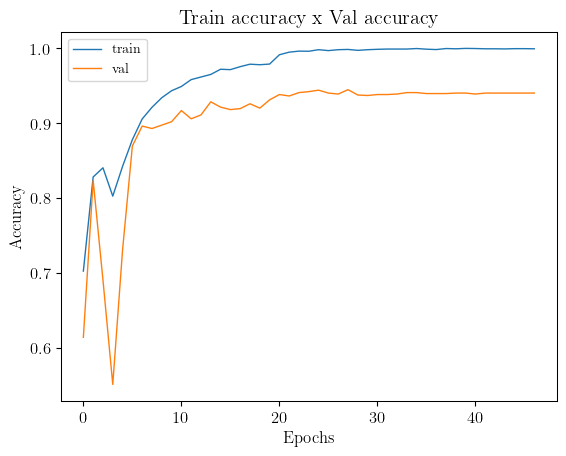

In [ ]:
# Gráfico de accurancy x val_accurancy
plt.plot(historyInception.history['accuracy'], label='accuracy')
plt.plot(historyInception.history['val_accuracy'], label = 'val_accuracy')
plt.title('Train accuracy x Val accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train','val'])

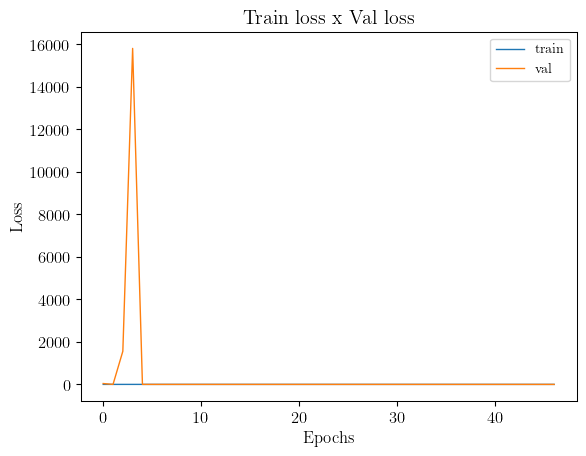

In [ ]:
# Gráfico de loss x val_loss
plt.plot(historyInception.history['loss'], label='loss')
plt.plot(historyInception.history['val_loss'], label = 'val_loss')
plt.title('Train loss x Val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.legend(['train','val'])

<Axes: >

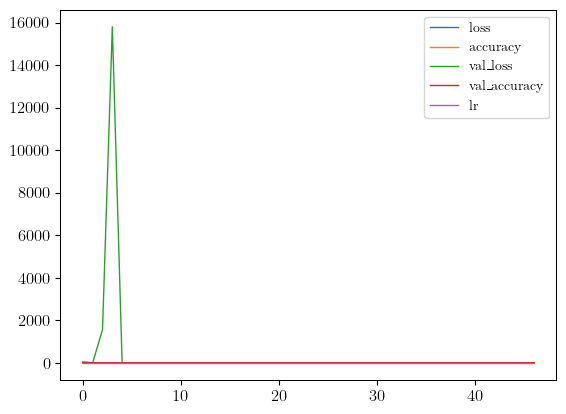

In [ ]:
# Gráfico de loss x val_loss e accurancy x val_accurancy
pd.DataFrame(modelInception.history.history).plot()

In [ ]:
# Realiza predição do dataset de Validação
val_generator.reset()
pred=modelInception.predict(val_generator, verbose=1)
predicted_class_indices=np.argmax(pred,axis=1)

25/25 [==============================] - 5s 205ms/step


In [ ]:
# Calcula a acurácia do dataset de Validação
acuracia = accuracy_score(val_generator.classes, predicted_class_indices)
print("A acurácia é de {0}%".format(round(acuracia * 100,2)))

A acurácia é de 94.03%


<Axes: >

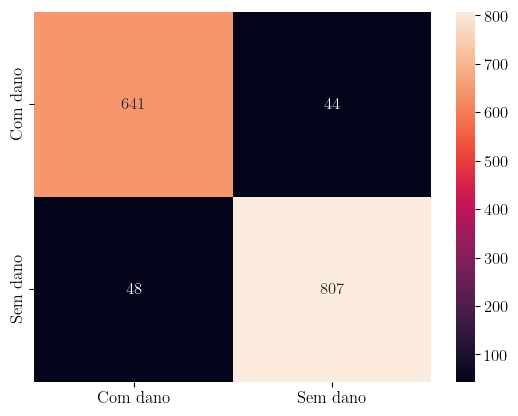

In [ ]:
# Platagem da matrix de confusão do dataset de Validação
cm = pd.DataFrame(data=confusion_matrix(val_generator.classes, predicted_class_indices))
sns.heatmap(cm,annot=True,fmt="d", xticklabels=['Com dano', 'Sem dano'], yticklabels=['Com dano', 'Sem dano'])

In [ ]:
# Relatório de classificação do modelo para o dataset de Validação
print(classification_report(val_generator.classes, predicted_class_indices, digits=4, target_names=['Com dano', 'Sem dano']))

              precision    recall  f1-score   support

    Com dano     0.9303    0.9358    0.9330       685
    Sem dano     0.9483    0.9439    0.9461       855

    accuracy                         0.9403      1540
   macro avg     0.9393    0.9398    0.9396      1540
weighted avg     0.9403    0.9403    0.9403      1540



In [ ]:
# Realiza predição do dataset de Testes
test_generator.reset()
predtest=modelInception.predict(test_generator, verbose=1)
predictedTest_class_indices=np.argmax(predtest,axis=1)

7/7 [==============================] - 1s 172ms/step


In [ ]:
# Calcula a acurácia do dataset de Testes
acuraciaTest = accuracy_score(test_generator.classes, predictedTest_class_indices)
print("A acurácia é de {0}%".format(round(acuraciaTest * 100,2)))

A acurácia é de 92.99%


<Axes: >

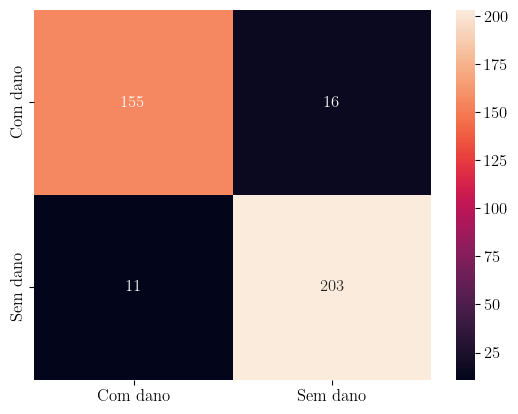

In [ ]:
# Platagem da matrix de confusão do dataset de Testes
cmTest = pd.DataFrame(data=confusion_matrix(test_generator.classes, predictedTest_class_indices))
sns.heatmap(cmTest,annot=True,fmt="d", xticklabels=['Com dano', 'Sem dano'], yticklabels=['Com dano', 'Sem dano'])

In [ ]:
# Relatório de classificação do modelo para o dataset de Testes
labels = (test_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
print(classification_report(test_generator.classes, predictedTest_class_indices, digits=4, target_names=['Com dano', 'Sem Dano']))

              precision    recall  f1-score   support

    Com dano     0.9337    0.9064    0.9199       171
    Sem Dano     0.9269    0.9486    0.9376       214

    accuracy                         0.9299       385
   macro avg     0.9303    0.9275    0.9288       385
weighted avg     0.9300    0.9299    0.9298       385



In [ ]:
# Mostra classificação - percentual de classificação - rótulo verdadeiro da imagem
classes = {0: 'Com dano', 1:'Sem dano'}
imagens = np.concatenate([test_generator[i] for i in range(test_generator.__len__())])
i = 44
previsto = np.argmax(predtest[i])
percentual = np.max(predtest[i])
real = test_generator.classes[i]
imagemReal = imagens[i]

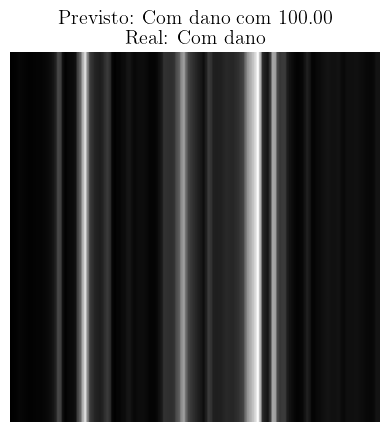

In [ ]:
# Plota predição de teste
plt.title('Previsto: ' + classes[previsto] + ' com ' + '{:.2%}'.format(round(percentual,2)) + '. \nReal: ' + classes[real])
plt.imshow(np.squeeze(imagemReal))
plt.axis('off')
plt.show()

In [ ]:
# Plota predições de teste
classes = {0: 'Sem dano', 1:'Com dano'}
imagens = np.concatenate([test_generator[i] for i in range(test_generator.__len__())])
plt.figure(figsize=(20, 20))
start = 0

for i in range(0, 16):

    plt.subplot(4, 4, i+1)

    # Mostra classificação - percentual de classificação - rótulo verdadeiro da imagem
    previsto = np.argmax(predtest[i])
    percentual = np.max(predtest[i])
    real = test_generator.classes[i]
    imagemReal = imagens[i]
    plt.title('Classificado como ' + classes[previsto] + ' com ' + '{:.2%}'.format(round(percentual,2)) + '. \nRótulo verdadeiro: ' + classes[real])
    plt.axis('off')
    plt.imshow(np.squeeze(imagemReal))

plt.tight_layout()
plt.show()